In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Text processing
import nltk
from textblob import TextBlob
from wordcloud import WordCloud
import re

# Image processing
from PIL import Image
import cv2

# Interactive visualizations
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style for matplotlib
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ All libraries imported successfully!")
print(f"📊 Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ All libraries imported successfully!
📊 Analysis started at: 2025-07-13 19:35:49


In [2]:
# Configuration and paths
DATA_DIR = Path("../data")
RAW_DATA_DIR = DATA_DIR / "raw" / "telegram_messages"
IMAGES_DIR = DATA_DIR / "images"
LOGS_DIR = DATA_DIR / "logs"

# Find the most recent data directory
available_dates = [d for d in RAW_DATA_DIR.glob("*") if d.is_dir()]
if not available_dates:
    raise FileNotFoundError("No scraped data found! Please run the scraper first.")

latest_date = max(available_dates, key=lambda x: x.name)
print(f"📅 Using data from: {latest_date.name}")

# Data file paths
COMBINED_DATA_FILE = latest_date / "combined_medical_channels.json"
METADATA_FILE = latest_date / "scrape_metadata.json"

# Check if files exist
if not COMBINED_DATA_FILE.exists():
    raise FileNotFoundError(f"Combined data file not found: {COMBINED_DATA_FILE}")
if not METADATA_FILE.exists():
    raise FileNotFoundError(f"Metadata file not found: {METADATA_FILE}")

print(f"📁 Data directory: {latest_date}")
print(f"📊 Combined data file: {COMBINED_DATA_FILE.name}")
print(f"📋 Metadata file: {METADATA_FILE.name}")
print(f"🖼️  Images directory: {IMAGES_DIR}")
print("✅ Configuration completed!")


📅 Using data from: 2025-07-13
📁 Data directory: ..\data\raw\telegram_messages\2025-07-13
📊 Combined data file: combined_medical_channels.json
📋 Metadata file: scrape_metadata.json
🖼️  Images directory: ..\data\images
✅ Configuration completed!


In [3]:
# Load and examine the data
print("🔍 Loading scraped data...")

# Load combined data
with open(COMBINED_DATA_FILE, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

# Load metadata
with open(METADATA_FILE, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(raw_data)
print(f"📊 Loaded {len(df)} messages")

# Display metadata
print("\n📋 Scraping Metadata:")
print(f"  Scrape Date: {metadata.get('scrape_date', 'Unknown')}")
print(f"  Total Messages: {metadata.get('total_messages', 'Unknown'):,}")
print(f"  Channels Scraped: {len(metadata.get('channels_scraped', []))}")

print("\n📈 Channel Statistics:")
for channel, count in metadata.get('channel_counts', {}).items():
    print(f"  {channel}: {count:,} messages")

print("\n📊 DataFrame Info:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {list(df.columns)}")
print(f"  Memory Usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

# Display first few rows
print("\n📋 Sample Data:")
df.head()


🔍 Loading scraped data...
📊 Loaded 1285 messages

📋 Scraping Metadata:
  Scrape Date: 2025-07-13
  Total Messages: 1,285
  Channels Scraped: 2

📈 Channel Statistics:
  @lobelia4cosmetics: 491 messages
  @tikvahpharma: 794 messages

📊 DataFrame Info:
  Shape: (1285, 11)
  Columns: ['id', 'channel', 'date', 'text', 'views', 'forwards', 'replies', 'media_type', 'media_path', 'raw_data', 'media_size']
  Memory Usage: 4.31 MB

📋 Sample Data:


,id,channel,date,text,views,forwards,replies,media_type,media_path,raw_data,media_size
0,18545,@lobelia4cosmetics,2025-07-13T13:07:02+00:00,AQUAPHOR BABY **\nPrice 5000 birr \nTelegram *...,323.0,0.0,0,photo,images\lobelia4cosmetics\18545_20250713_184232...,"{'message_id': 18545, 'from_id': None, 'reply_...",82866.0
1,18544,@lobelia4cosmetics,2025-07-13T13:07:02+00:00,AVEENO BABY \nPrice 5000 birr \nTelegram :-@Lo...,280.0,0.0,0,photo,images\lobelia4cosmetics\18544_20250713_184235...,"{'message_id': 18544, 'from_id': None, 'reply_...",28531.0
2,18543,@lobelia4cosmetics,2025-07-13T13:07:02+00:00,ARGON OIL \nPrice 5000 birr \nTelegram https:/...,114.0,0.0,0,photo,images\lobelia4cosmetics\18543_20250713_184237...,"{'message_id': 18543, 'from_id': None, 'reply_...",17233.0
3,18542,@lobelia4cosmetics,2025-07-13T13:07:02+00:00,BIO OIL \nPrice 3000 birr \nTelegram https://t...,170.0,0.0,0,photo,images\lobelia4cosmetics\18542_20250713_184239...,"{'message_id': 18542, 'from_id': None, 'reply_...",21779.0
4,18541,@lobelia4cosmetics,2025-07-13T13:07:02+00:00,VITAMIN D3 1000IU 650 SOFT GELS \nPrice 6500 b...,67.0,0.0,0,photo,images\lobelia4cosmetics\18541_20250713_184241...,"{'message_id': 18541, 'from_id': None, 'reply_...",21590.0


In [4]:
# Data preprocessing and cleaning
print("🧹 Preprocessing data...")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Add derived columns
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Clean text data
df['text_length'] = df['text'].str.len()
df['has_media'] = df['media_type'].notna()
df['word_count'] = df['text'].str.split().str.len()

# Clean channel names for better display
df['channel_clean'] = df['channel'].str.replace('@', '', regex=False)

# Filter out empty messages
df_clean = df[df['text'].str.len() > 0].copy()

print(f"📊 Data after preprocessing:")
print(f"  Total messages: {len(df):,}")
print(f"  Messages with text: {len(df_clean):,}")
print(f"  Messages with media: {df['has_media'].sum():,}")
print(f"  Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")

# Display basic statistics
print("\n📈 Basic Statistics:")
print(df_clean[['text_length', 'word_count', 'views', 'forwards']].describe())


🧹 Preprocessing data...
📊 Data after preprocessing:
  Total messages: 1,285
  Messages with text: 1,224
  Messages with media: 731
  Date range: 2025-06-13 to 2025-07-13

📈 Basic Statistics:
       text_length   word_count         views     forwards
count  1224.000000  1224.000000   1198.000000  1198.000000
mean    807.095588   110.681373   2197.151085     3.505843
std     986.400840   126.893881   6782.736405    14.407585
min       9.000000     1.000000     67.000000     0.000000
25%     361.000000    58.000000    506.250000     0.000000
50%     398.000000    64.000000    657.000000     0.000000
75%     708.000000    89.000000    854.000000     2.000000
max    3989.000000   595.000000  56627.000000   153.000000


📊 Analyzing channel activity...
📈 Channel Statistics:
                   Messages  Avg_Text_Length  Median_Text_Length  \
channel_clean                                                      
tikvahpharma            750          1073.77               550.0   
lobelia4cosmetics       474           385.14               386.0   

                   Avg_Word_Count  Median_Word_Count  Avg_Views  Median_Views  \
channel_clean                                                                   
tikvahpharma               140.42               73.0    3211.28         699.5   
lobelia4cosmetics           63.63               64.0     648.15         600.0   

                   Max_Views  Avg_Forwards  Median_Forwards  Max_Forwards  \
channel_clean                                                               
tikvahpharma         56627.0          5.11              0.0         153.0   
lobelia4cosmetics     5276.0          1.06              1.0          13.0   

                   Media_Count  
channe

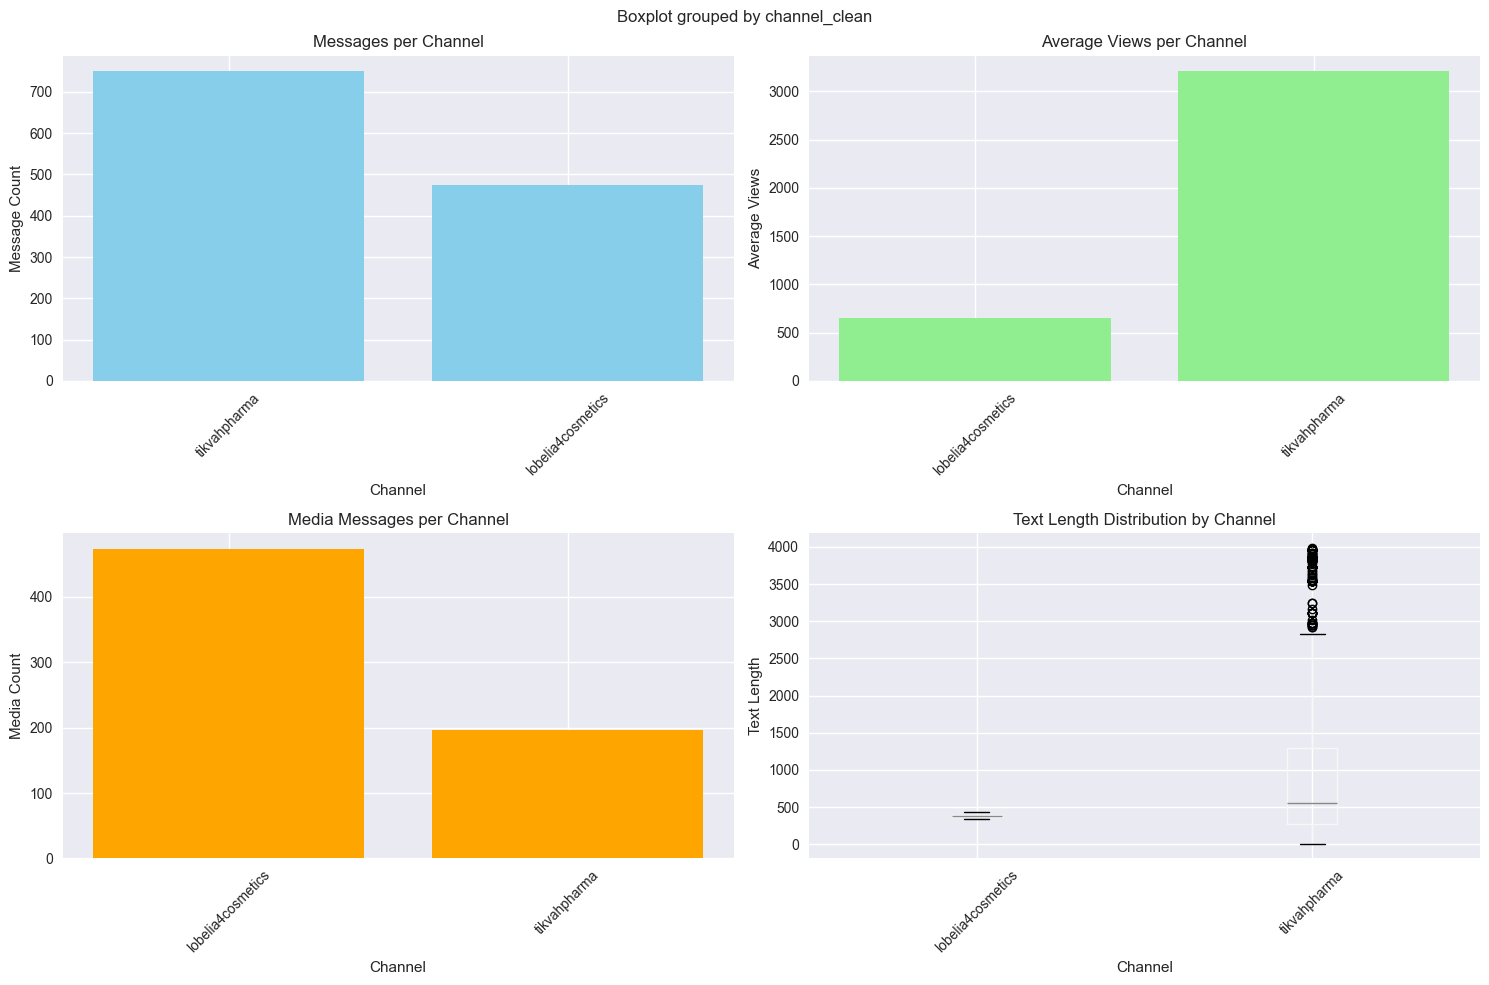

In [5]:
# Channel Analysis and Comparison
print("📊 Analyzing channel activity...")

# Channel statistics
channel_stats = df_clean.groupby('channel_clean').agg({
    'id': 'count',
    'text_length': ['mean', 'median'],
    'word_count': ['mean', 'median'],
    'views': ['mean', 'median', 'max'],
    'forwards': ['mean', 'median', 'max'],
    'has_media': 'sum'
}).round(2)

channel_stats.columns = ['Messages', 'Avg_Text_Length', 'Median_Text_Length', 
                        'Avg_Word_Count', 'Median_Word_Count', 'Avg_Views', 
                        'Median_Views', 'Max_Views', 'Avg_Forwards', 
                        'Median_Forwards', 'Max_Forwards', 'Media_Count']

print("📈 Channel Statistics:")
print(channel_stats.sort_values('Messages', ascending=False))

# Visualization: Channel message counts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Messages per channel
channel_counts = df_clean['channel_clean'].value_counts()
axes[0, 0].bar(channel_counts.index, channel_counts.values, color='skyblue')
axes[0, 0].set_title('Messages per Channel')
axes[0, 0].set_xlabel('Channel')
axes[0, 0].set_ylabel('Message Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Average views per channel
avg_views = df_clean.groupby('channel_clean')['views'].mean()
axes[0, 1].bar(avg_views.index, avg_views.values, color='lightgreen')
axes[0, 1].set_title('Average Views per Channel')
axes[0, 1].set_xlabel('Channel')
axes[0, 1].set_ylabel('Average Views')
axes[0, 1].tick_params(axis='x', rotation=45)

# Media distribution
media_counts = df_clean.groupby('channel_clean')['has_media'].sum()
axes[1, 0].bar(media_counts.index, media_counts.values, color='orange')
axes[1, 0].set_title('Media Messages per Channel')
axes[1, 0].set_xlabel('Channel')
axes[1, 0].set_ylabel('Media Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Text length distribution
df_clean.boxplot(column='text_length', by='channel_clean', ax=axes[1, 1])
axes[1, 1].set_title('Text Length Distribution by Channel')
axes[1, 1].set_xlabel('Channel')
axes[1, 1].set_ylabel('Text Length')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


⏰ Analyzing temporal patterns...


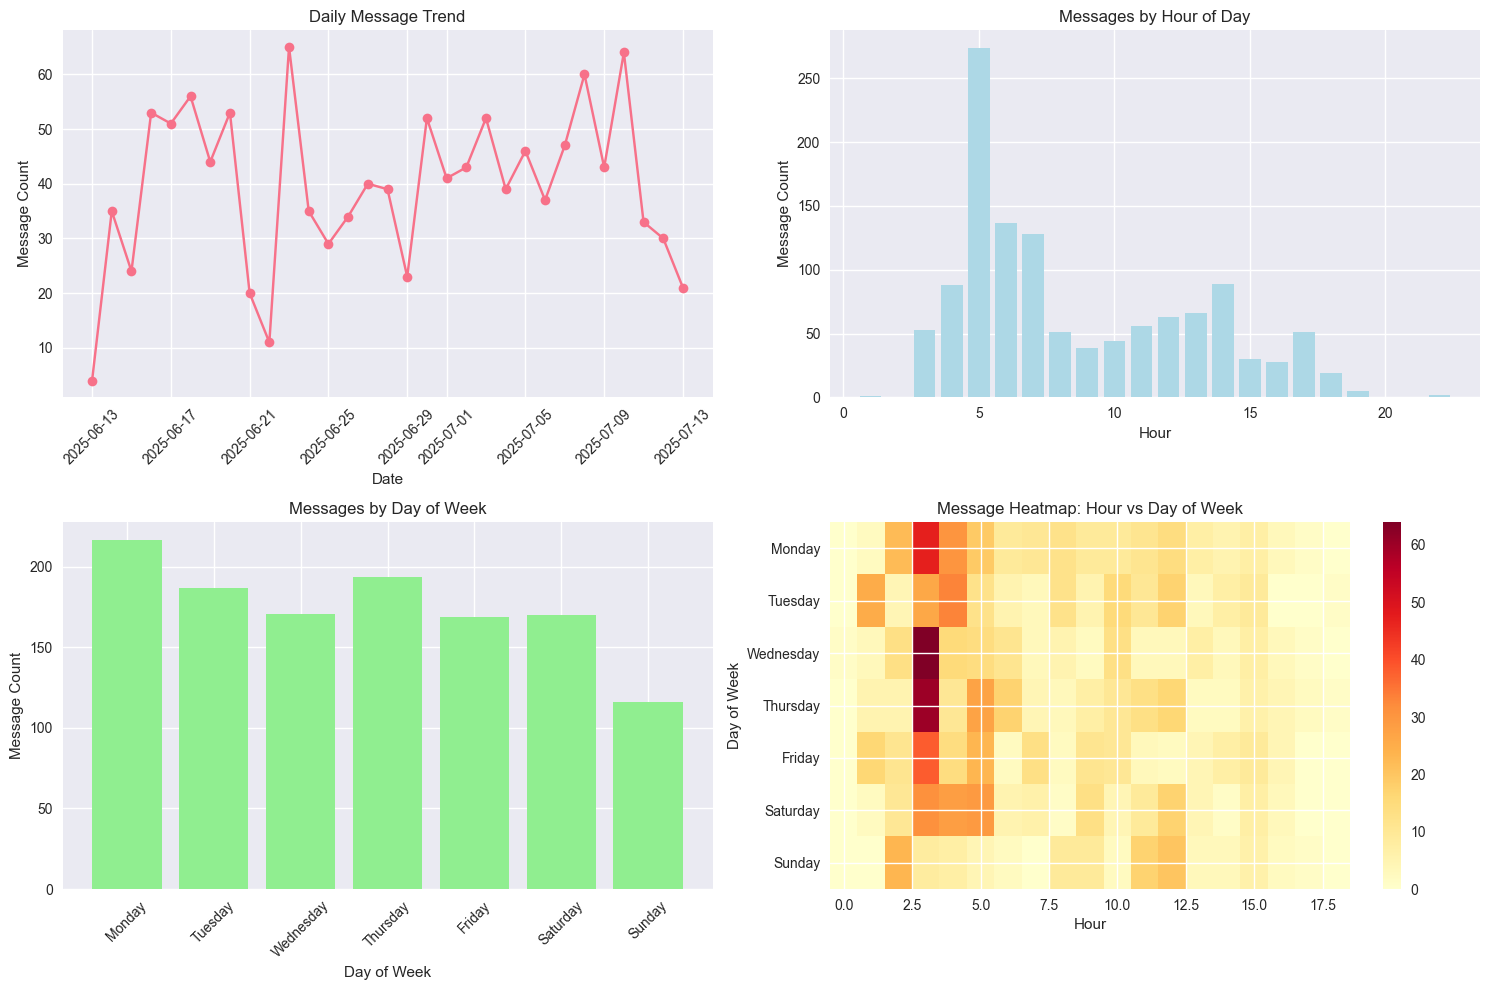


🔥 Peak Activity Analysis:
  Peak Hour: 5:00 (274 messages)
  Peak Day: Monday (217 messages)
  Most Active Date: 2025-06-23 (65 messages)


In [6]:
# Temporal Analysis
print("⏰ Analyzing temporal patterns...")

# Messages over time
daily_messages = df_clean.groupby(df_clean['date'].dt.date).size()
hourly_messages = df_clean.groupby('hour').size()
dow_messages = df_clean.groupby('day_of_week').size()

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Daily message trend
axes[0, 0].plot(daily_messages.index, daily_messages.values, marker='o')
axes[0, 0].set_title('Daily Message Trend')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Message Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Hourly distribution
axes[0, 1].bar(hourly_messages.index, hourly_messages.values, color='lightblue')
axes[0, 1].set_title('Messages by Hour of Day')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Message Count')

# Day of week distribution
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_ordered = dow_messages.reindex(day_order)
axes[1, 0].bar(dow_ordered.index, dow_ordered.values, color='lightgreen')
axes[1, 0].set_title('Messages by Day of Week')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Message Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Heatmap: Hour vs Day of Week
pivot_data = df_clean.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)
pivot_data = pivot_data.reindex(day_order)
im = axes[1, 1].imshow(pivot_data, cmap='YlOrRd', aspect='auto')
axes[1, 1].set_title('Message Heatmap: Hour vs Day of Week')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Day of Week')
axes[1, 1].set_yticks(range(len(day_order)))
axes[1, 1].set_yticklabels(day_order)
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# Peak activity analysis
print("\n🔥 Peak Activity Analysis:")
peak_hour = hourly_messages.idxmax()
peak_day = dow_messages.idxmax()
most_active_date = daily_messages.idxmax()

print(f"  Peak Hour: {peak_hour}:00 ({hourly_messages[peak_hour]} messages)")
print(f"  Peak Day: {peak_day} ({dow_messages[peak_day]} messages)")
print(f"  Most Active Date: {most_active_date} ({daily_messages[most_active_date]} messages)")


📝 Analyzing text content...
📊 Message Categories:
  pharmacy: 718 messages (58.7%)
  other: 247 messages (20.2%)
  cosmetics: 99 messages (8.1%)
  healthcare: 80 messages (6.5%)
  medical_equipment: 80 messages (6.5%)


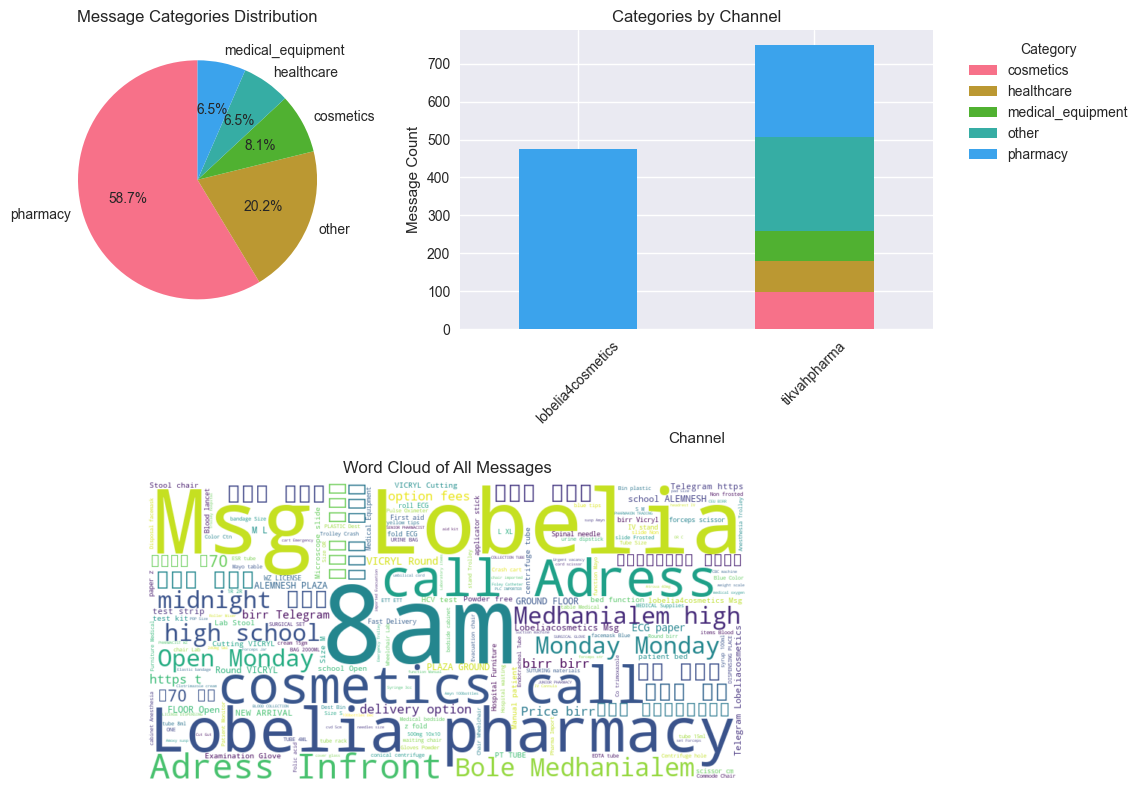

In [7]:
# Text Analysis and Medical Content Classification
print("📝 Analyzing text content...")

# Combine all text for analysis
all_text = ' '.join(df_clean['text'].astype(str))

# Medical keywords for classification
medical_keywords = {
    'pharmacy': ['መድኃኒት', 'ኪኒን', 'ቅምጡ', 'pharmacy', 'medicine', 'drug', 'tablet', 'capsule', 'syrup'],
    'cosmetics': ['ቆዳ', 'ወለል', 'ግሮም', 'cosmetic', 'beauty', 'skin', 'face', 'cream', 'lotion'],
    'medical_equipment': ['መሳሪያ', 'ማሽን', 'equipment', 'device', 'machine', 'tool', 'instrument'],
    'healthcare': ['ጤና', 'ሕክምና', 'ዶክተር', 'health', 'doctor', 'clinic', 'hospital', 'treatment'],
    'wellness': ['ፈውስ', 'ቪታሚን', 'wellness', 'vitamin', 'supplement', 'nutrition', 'fitness']
}

# Categorize messages
def categorize_message(text):
    text_lower = text.lower()
    categories = []
    
    for category, keywords in medical_keywords.items():
        if any(keyword in text_lower for keyword in keywords):
            categories.append(category)
    
    return categories if categories else ['other']

# Apply categorization
df_clean['categories'] = df_clean['text'].apply(categorize_message)
df_clean['primary_category'] = df_clean['categories'].apply(lambda x: x[0] if x else 'other')

# Category distribution
category_counts = df_clean['primary_category'].value_counts()
print("📊 Message Categories:")
for category, count in category_counts.items():
    print(f"  {category}: {count:,} messages ({count/len(df_clean)*100:.1f}%)")

# Visualize categories
plt.figure(figsize=(12, 8))

# Category distribution pie chart
plt.subplot(2, 2, 1)
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Message Categories Distribution')

# Category by channel
plt.subplot(2, 2, 2)
category_channel = pd.crosstab(df_clean['channel_clean'], df_clean['primary_category'])
category_channel.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Categories by Channel')
plt.xlabel('Channel')
plt.ylabel('Message Count')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Word cloud
plt.subplot(2, 1, 2)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Messages')

plt.tight_layout()
plt.show()


🖼️ Analyzing media content...
📊 Media Statistics by Channel:
                   Media_Count  Avg_Size_MB  Total_Size_MB
channel_clean                                             
lobelia4cosmetics          474      64926.7     30775256.0
tikvahpharma               197     214641.9     42284454.0

📈 Media Types Distribution:
  photo: 668 files
  video: 3 files


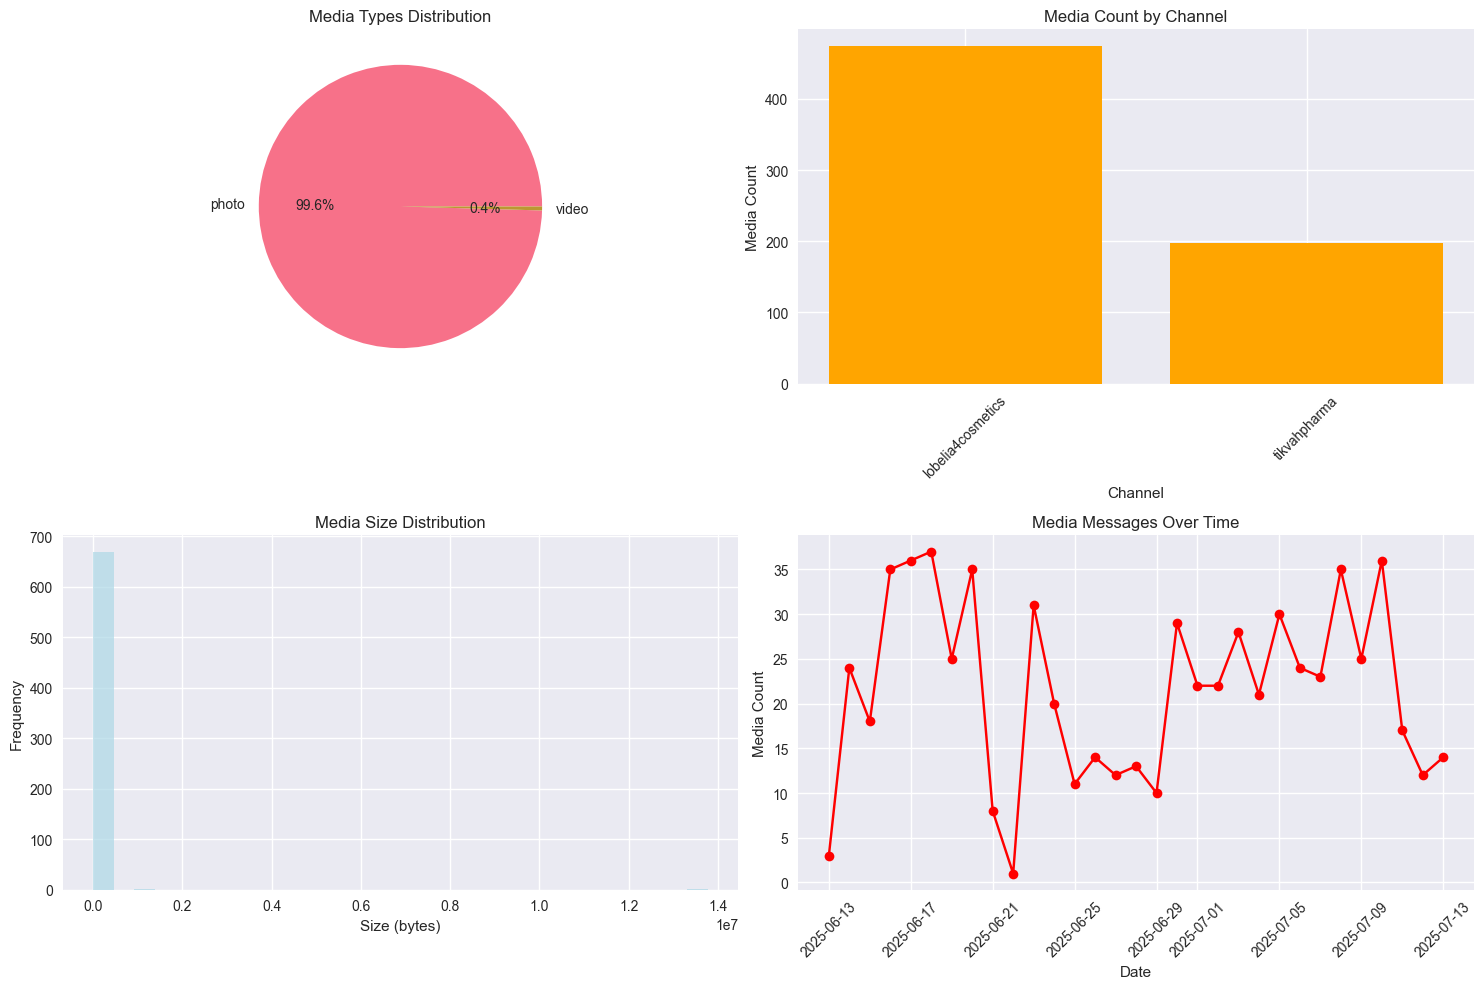


🖼️ Image Analysis:
  lobelia4cosmetics: 523 images
    18038_20250713_190152.jpg: (1280, 1280) pixels, RGB mode
    18039_20250713_190150.jpg: (500, 500) pixels, RGB mode
    18040_20250713_190148.jpg: (679, 679) pixels, RGB mode
    18041_20250713_190146.jpg: (450, 450) pixels, RGB mode
    18042_20250713_190143.jpg: (299, 400) pixels, RGB mode
  tikvahpharma: 237 images
    170310_20250713_193305.jpg: (720, 310) pixels, RGB mode
    170314_20250713_193301.jpg: (720, 310) pixels, RGB mode
    170315_20250713_193258.jpg: (1280, 960) pixels, RGB mode
    170326_20250713_193254.jpg: (720, 310) pixels, RGB mode
    170343_20250713_193249.jpg: (823, 1280) pixels, RGB mode


In [8]:
# Media and Image Analysis
print("🖼️ Analyzing media content...")

# Media statistics
media_stats = df_clean[df_clean['has_media']].groupby('channel_clean').agg({
    'media_type': 'count',
    'media_size': ['mean', 'sum']
}).round(2)

if not media_stats.empty:
    media_stats.columns = ['Media_Count', 'Avg_Size_MB', 'Total_Size_MB']
    print("📊 Media Statistics by Channel:")
    print(media_stats)

# Analyze media types
media_types = df_clean['media_type'].value_counts()
print(f"\n📈 Media Types Distribution:")
for media_type, count in media_types.items():
    print(f"  {media_type}: {count:,} files")

# Visualize media analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Media type distribution
if not media_types.empty:
    axes[0, 0].pie(media_types.values, labels=media_types.index, autopct='%1.1f%%')
    axes[0, 0].set_title('Media Types Distribution')

# Media count by channel
media_by_channel = df_clean.groupby('channel_clean')['has_media'].sum()
axes[0, 1].bar(media_by_channel.index, media_by_channel.values, color='orange')
axes[0, 1].set_title('Media Count by Channel')
axes[0, 1].set_xlabel('Channel')
axes[0, 1].set_ylabel('Media Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Media size distribution
media_with_size = df_clean[df_clean['media_size'] > 0]
if not media_with_size.empty:
    axes[1, 0].hist(media_with_size['media_size'], bins=30, alpha=0.7, color='lightblue')
    axes[1, 0].set_title('Media Size Distribution')
    axes[1, 0].set_xlabel('Size (bytes)')
    axes[1, 0].set_ylabel('Frequency')

# Media over time
media_over_time = df_clean[df_clean['has_media']].groupby(df_clean['date'].dt.date).size()
if not media_over_time.empty:
    axes[1, 1].plot(media_over_time.index, media_over_time.values, marker='o', color='red')
    axes[1, 1].set_title('Media Messages Over Time')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Media Count')
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Image analysis (if images exist)
if IMAGES_DIR.exists():
    print("\n🖼️ Image Analysis:")
    image_channels = [d for d in IMAGES_DIR.iterdir() if d.is_dir()]
    
    for channel_dir in image_channels:
        image_files = list(channel_dir.glob("*.jpg")) + list(channel_dir.glob("*.png"))
        print(f"  {channel_dir.name}: {len(image_files)} images")
        
        # Analyze a sample of images
        if image_files:
            sample_images = image_files[:5]  # Analyze first 5 images
            
            for img_path in sample_images:
                try:
                    img = Image.open(img_path)
                    print(f"    {img_path.name}: {img.size} pixels, {img.mode} mode")
                except Exception as e:
                    print(f"    {img_path.name}: Error reading - {e}")
else:
    print("📁 No images directory found")


🔍 Generating advanced insights...
🏆 Top 10 Most Engaging Posts:

tikvahpharma (Score: 56889)
Views: 56627.0, Forwards: 131.0
Text: https://t.me/himedmedicalequipment
🔤🔤🔤🔤🔤 🔤🅰️🔤🔤🔤

New arrivals from Pakistan 

Abdominal retractor Do...

tikvahpharma (Score: 56889)
Views: 56627.0, Forwards: 131.0
Text: https://t.me/himedmedicalequipment
🔤🔤🔤🔤🔤 🔤🅰️🔤🔤🔤

New arrivals from Pakistan 

Abdominal retractor Do...

tikvahpharma (Score: 56889)
Views: 56627.0, Forwards: 131.0
Text: https://t.me/himedmedicalequipment
🔤🔤🔤🔤🔤 🔤🅰️🔤🔤🔤

New arrivals from Pakistan 

Abdominal retractor Do...

tikvahpharma (Score: 56889)
Views: 56627.0, Forwards: 131.0
Text: https://t.me/himedmedicalequipment
🔤🔤🔤🔤🔤 🔤🅰️🔤🔤🔤

New arrivals from Pakistan 

Abdominal retractor Do...

tikvahpharma (Score: 56888)
Views: 56626.0, Forwards: 131.0
Text: https://t.me/himedmedicalequipment
🔤🔤🔤🔤🔤 🔤🅰️🔤🔤🔤

New arrivals from Pakistan 

Abdominal retractor Do...

tikvahpharma (Score: 56888)
Views: 56626.0, Forwards: 131.0
Text: https://t.me/h

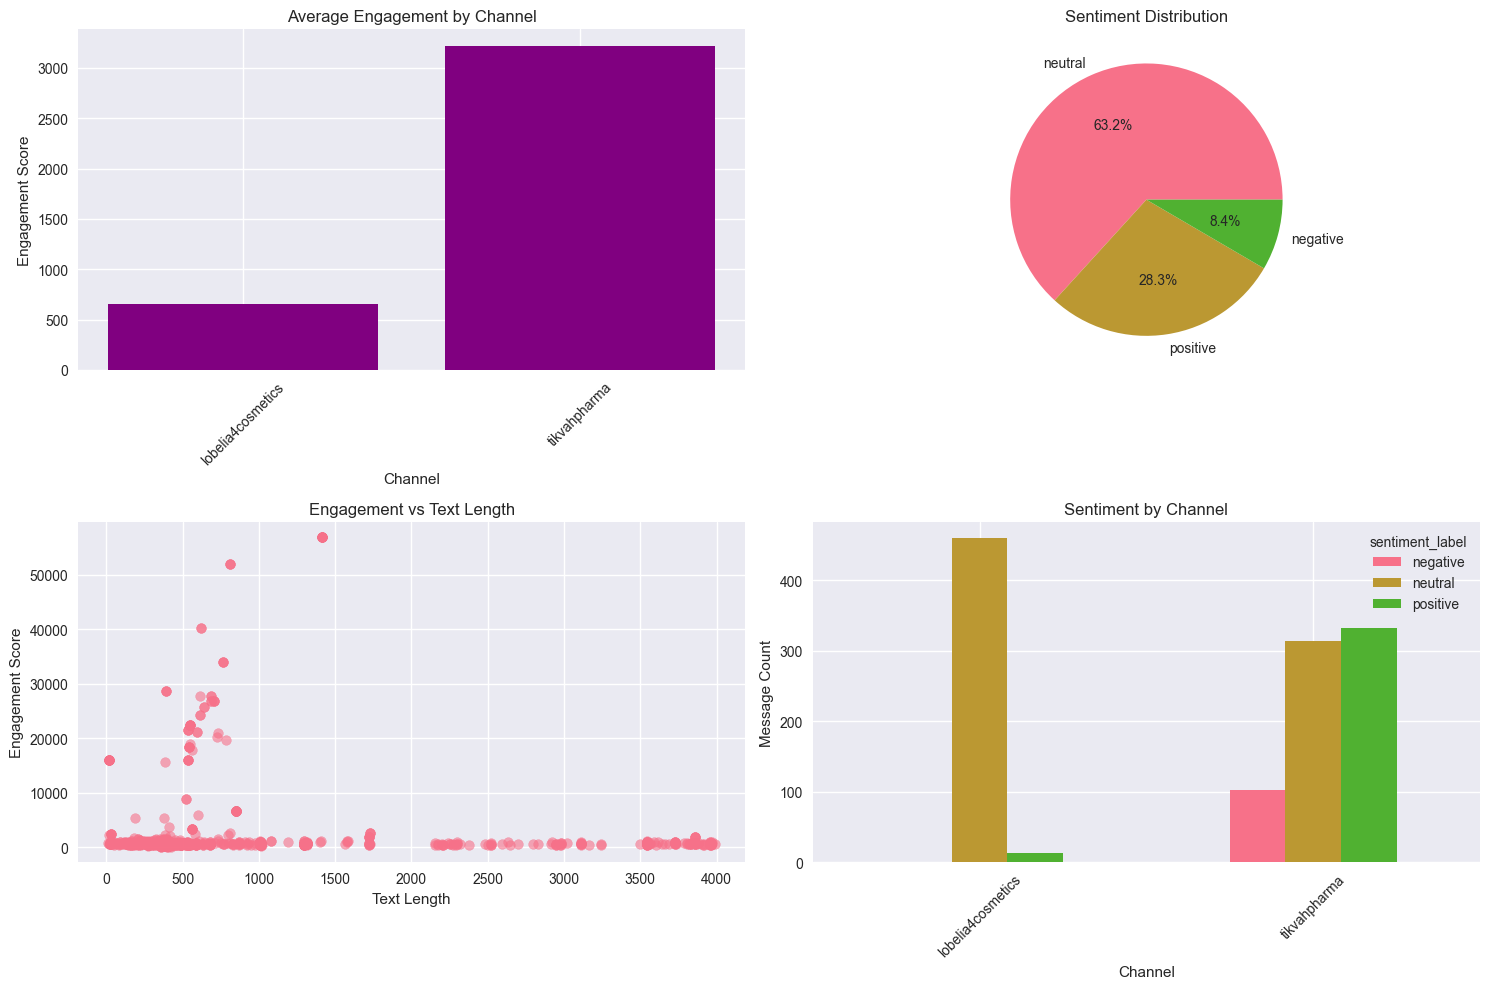

In [9]:
# Advanced Analytics and Insights
print("🔍 Generating advanced insights...")

# Engagement analysis
df_clean['engagement_score'] = df_clean['views'] + (df_clean['forwards'] * 2)
df_clean['engagement_per_word'] = df_clean['engagement_score'] / df_clean['word_count'].replace(0, 1)

# Top performing content
top_posts = df_clean.nlargest(10, 'engagement_score')[['channel_clean', 'text', 'views', 'forwards', 'engagement_score']]
print("🏆 Top 10 Most Engaging Posts:")
for idx, post in top_posts.iterrows():
    print(f"\n{post['channel_clean']} (Score: {post['engagement_score']:.0f})")
    print(f"Views: {post['views']}, Forwards: {post['forwards']}")
    print(f"Text: {post['text'][:100]}...")

# Sentiment analysis (basic)
def simple_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df_clean['sentiment'] = df_clean['text'].apply(simple_sentiment)
df_clean['sentiment_label'] = df_clean['sentiment'].apply(
    lambda x: 'positive' if x > 0.1 else 'negative' if x < -0.1 else 'neutral'
)

# Sentiment distribution
sentiment_dist = df_clean['sentiment_label'].value_counts()
print(f"\n😊 Sentiment Distribution:")
for sentiment, count in sentiment_dist.items():
    print(f"  {sentiment}: {count:,} messages ({count/len(df_clean)*100:.1f}%)")

# Visualize advanced analytics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Engagement by channel
engagement_by_channel = df_clean.groupby('channel_clean')['engagement_score'].mean()
axes[0, 0].bar(engagement_by_channel.index, engagement_by_channel.values, color='purple')
axes[0, 0].set_title('Average Engagement by Channel')
axes[0, 0].set_xlabel('Channel')
axes[0, 0].set_ylabel('Engagement Score')
axes[0, 0].tick_params(axis='x', rotation=45)

# Sentiment distribution
axes[0, 1].pie(sentiment_dist.values, labels=sentiment_dist.index, autopct='%1.1f%%')
axes[0, 1].set_title('Sentiment Distribution')

# Engagement vs Text Length
axes[1, 0].scatter(df_clean['text_length'], df_clean['engagement_score'], alpha=0.6)
axes[1, 0].set_title('Engagement vs Text Length')
axes[1, 0].set_xlabel('Text Length')
axes[1, 0].set_ylabel('Engagement Score')

# Sentiment by channel
sentiment_channel = pd.crosstab(df_clean['channel_clean'], df_clean['sentiment_label'])
sentiment_channel.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Sentiment by Channel')
axes[1, 1].set_xlabel('Channel')
axes[1, 1].set_ylabel('Message Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [10]:
# Summary and Recommendations
print("📋 Analysis Summary and Recommendations")
print("=" * 50)

# Key findings
print("\n🔍 KEY FINDINGS:")
print(f"1. Data Overview:")
print(f"   - Total messages analyzed: {len(df_clean):,}")
print(f"   - Active channels: {df_clean['channel_clean'].nunique()}")
print(f"   - Date range: {df_clean['date'].min().strftime('%Y-%m-%d')} to {df_clean['date'].max().strftime('%Y-%m-%d')}")

print(f"\n2. Channel Performance:")
most_active_channel = df_clean['channel_clean'].value_counts().index[0]
highest_engagement_channel = df_clean.groupby('channel_clean')['engagement_score'].mean().idxmax()
print(f"   - Most active channel: {most_active_channel}")
print(f"   - Highest engagement: {highest_engagement_channel}")

print(f"\n3. Content Analysis:")
top_category = df_clean['primary_category'].value_counts().index[0]
avg_text_length = df_clean['text_length'].mean()
print(f"   - Top content category: {top_category}")
print(f"   - Average message length: {avg_text_length:.0f} characters")

print(f"\n4. Temporal Patterns:")
print(f"   - Peak posting hour: {hourly_messages.idxmax()}:00")
print(f"   - Most active day: {dow_messages.idxmax()}")

print(f"\n5. Media Content:")
media_percentage = (df_clean['has_media'].sum() / len(df_clean)) * 100
print(f"   - Messages with media: {media_percentage:.1f}%")

print(f"\n6. Sentiment Analysis:")
positive_pct = (df_clean['sentiment_label'] == 'positive').mean() * 100
print(f"   - Positive sentiment: {positive_pct:.1f}%")

print(f"\n💡 RECOMMENDATIONS:")
print("1. Content Strategy:")
print("   - Focus on high-engagement content types")
print("   - Optimize posting times (peak hours)")
print("   - Increase media content for better engagement")

print("\n2. Channel Management:")
print("   - Learn from top-performing channels")
print("   - Analyze successful content patterns")
print("   - Monitor sentiment trends")

print("\n3. Data Collection:")
print("   - Consider expanding to more channels")
print("   - Implement real-time monitoring")
print("   - Add more sophisticated NLP analysis")

print("\n4. Business Intelligence:")
print("   - Track engagement metrics over time")
print("   - Monitor competitor activity")
print("   - Identify trending medical topics")

print("\n📊 NEXT STEPS:")
print("1. Set up automated daily scraping")
print("2. Implement real-time dashboard")
print("3. Build predictive models for engagement")
print("4. Create content recommendation system")
print("5. Develop image classification for medical products")

print(f"\n✅ Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("📁 All results saved to the data directory")
print("🎯 Ready for next phase of analysis!")


📋 Analysis Summary and Recommendations

🔍 KEY FINDINGS:
1. Data Overview:
   - Total messages analyzed: 1,224
   - Active channels: 2
   - Date range: 2025-06-13 to 2025-07-13

2. Channel Performance:
   - Most active channel: tikvahpharma
   - Highest engagement: tikvahpharma

3. Content Analysis:
   - Top content category: pharmacy
   - Average message length: 807 characters

4. Temporal Patterns:
   - Peak posting hour: 5:00
   - Most active day: Monday

5. Media Content:
   - Messages with media: 54.8%

6. Sentiment Analysis:
   - Positive sentiment: 28.3%

💡 RECOMMENDATIONS:
1. Content Strategy:
   - Focus on high-engagement content types
   - Optimize posting times (peak hours)
   - Increase media content for better engagement

2. Channel Management:
   - Learn from top-performing channels
   - Analyze successful content patterns
   - Monitor sentiment trends

3. Data Collection:
   - Consider expanding to more channels
   - Implement real-time monitoring
   - Add more sophistica